# Topic/User Analysis

## Load Data

In [16]:
import sys
import os

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
)  # Adjust as needed
sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), "..", "..", "scripts"))
)  # Adjust as needed

import ast
from math import log2
from collections import Counter
import pandas as pd
import numpy as np

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

from utility import (
    get_user_frequent_topic,
    get_user_dominant_topic,
    topic_entropy,
    Log2,
    cramers_v,
    rank_biserial_from_u,
    # cliffs_delta,
    compare_groups,
    plot_entropy_distribution,
    plot_effective_topic_count,
)

import scripts.my_text_cleaning as tc


In [17]:
chosen_dataset = "ukraine_tweets_en"
chosen_dataset = "covid_tweets_en"
chosen_dataset = "cop26_tweets_en"
ur_df = pd.read_parquet("./../../data/raw/" + chosen_dataset + ".parquet")
# change type of 'author_id' to string
# to ensure character-by-character comparison
ur_df["author_id"] = ur_df["author_id"].astype(str)
ur_df = tc.clean_dataframe(
    ur_df,
    column_name="text",
    phrases_to_remove=["&gt;", "&lt;", "&amp;", "RT : "],
    remove_empty=False,
    normalize_hashtags=True,
    normalize_mentions=True,
    user_placeholder="user",
)
print(f"{chosen_dataset.replace('_tweets_en', '').upper()} dataset loaded.")
# print(ur_df.columns)
doc_info = pd.read_csv(
    "./../../data/processed/document_info_" + chosen_dataset + ".csv"
)[["Document", "Topic", "Representative_document", "Name"]]
doc_info.Topic = doc_info.Topic.astype(int)
print("Document-topic assignments loaded.")
# embeddings = np.load('./../../data/processed/'+chosen_dataset+'.parquet.npy')
# print(doc_info.columns)
usr_info = pd.read_csv("./../../data/raw/political_stance_merged.csv")
print("User metadata loaded.")
# print(usr_info.columns)  # merge on 'username'
# merge ur_df with doc_info on 'Cleantext' and 'Document'
# left join to keep all rows in ur_df
# check that length is the same before and after merge
merged_df = ur_df.merge(doc_info, left_on="Cleantext", right_on="Document", how="left")
assert len(merged_df) == len(ur_df), (
    "differing length before and after merge, duplicates in right"
)
print("Tweet-topic assignment merged.")

COP26 dataset loaded.
Document-topic assignments loaded.
User metadata loaded.
Tweet-topic assignment merged.


## Assign Topic to Users
Many strategies were employed to assign topics to users, resulting in different retention percentages and interpretations.
- frequency: easy interpretation, higher retention.
- entropy: clearer interpretation, lower retention.

Both strategies return the most common topic.
In each case noise topic is excluded from computation.
If no topic is found that meets the requirements, no topic is assigned.


### Frequency to assign Topics to Users
Group topics by users, and assign the dominant topic using a frequency threshold.

The most frequent topic that exceeds exceeds the threshold, it is assigned to a user as the dominant one.
On ties, the topic with lowest id is assigned.

**TLDR: Frequency = Raw numbers**

### Entropy to assign Topics to Users

If we want to assign topics unambigously to all users, we can use entropy to assign them.

We assign a topic only if entropy of the user's topic distribution is low, i.e., user is focused.
To do so, we compute entropy of users' topic distributions, excluding noise (topic -1).

Then, we prevent the assignment of topics in the presence of ties.

**TLDR: Entropy = User Focus**
| Entropy | Interpretation                                             |
| ------- | ---------------------------------------------------------- |
| 0       | All tweets in one topic (perfect focus)                    |
| \~1     | Tweets mostly in 2 topics                                  |
| \~2     | Tweets across 4 topics fairly evenly                       |
| \~3     | Tweets across \~8 topics                                   |
| \~4     | Tweets across \~16 topics                                  |
| ...     | ... (upper limit is $\log_2(N)$, where $N$ = total topics) |


#### User Retention
Different strategies lead to different assignments to users.
Frequency strategy assigns topics to less users with higher frequency, whereas lower frequencies lead to more deterministic assignments.
Entropy is able to assign more users with a dominant topic with low thresholds, but still 5% of users are left with unassigned topics with a maximum entropy of 3 (8 or more prevalent topics).

Arguably, entropy is a sounder strategy.

In [18]:
# Group topics by user
user_topics = merged_df.groupby("author_id")["Topic"].apply(list)

# Compute entropy of topic distributions among users.
user_topic_entropy = user_topics.apply(topic_entropy)

# Parameter grids
entropy_thresholds = {
    "dominant_topic_2": log2(2),  # max entropy ~ 1
    "dominant_topic_3": log2(3),  # ~ 1.58
    "dominant_topic_4": log2(4),  # 2
    "dominant_topic_5": log2(5),  # ~ 2.32
    "dominant_topic_6": log2(6),  # ~ 2.58
    "dominant_topic_8": log2(8),  # 3
}

frequency_thresholds = {
    "frequent_topic_60": 0.6,
    "frequent_topic_50": 0.5,
    "frequent_topic_30": 0.3,
    "frequent_topic_20": 0.2,
    "frequent_topic_10": 0.1,
}

# Apply entropy-based strategy
entropy_results = {
    name: user_topics.apply(
        lambda topics, thr=thr: get_user_dominant_topic(topics, max_entropy=thr)
    )
    for name, thr in entropy_thresholds.items()
}

# Apply frequency-based strategy
frequency_results = {
    name: user_topics.apply(
        lambda topics, thr=thr: get_user_frequent_topic(topics, threshold=thr)
    )
    for name, thr in frequency_thresholds.items()
}

# Combine results into a DataFrame
result = pd.DataFrame(
    {
        "topic_entropy": user_topic_entropy,
        "effective_topic_number": np.exp2(user_topic_entropy),
        **entropy_results,
        **frequency_results,
    }
)

# Ensure index is string for comparisons
result.index = result.index.astype(str)


# -------- Reporting --------
def retention(series: pd.Series) -> float:
    """Compute retention percentage (non-null values)."""
    return 100 * (1 - series.isna().mean())


print("User retention by entropy thresholds:")
for name, thr in entropy_thresholds.items():
    print(f"  H < {thr:.2f}: {retention(result[name]):.1f}%")

print("\nUser retention by frequency thresholds:")
for name, thr in frequency_thresholds.items():
    print(f" freq ≥ {int(thr * 100)}%: {retention(result[name]):.1f}%")

User retention by entropy thresholds:
  H < 1.00: 32.8%
  H < 1.58: 80.0%
  H < 2.00: 97.3%
  H < 2.32: 99.6%
  H < 2.58: 99.6%
  H < 3.00: 99.6%

User retention by frequency thresholds:
 freq ≥ 60%: 69.2%
 freq ≥ 50%: 85.0%
 freq ≥ 30%: 98.8%
 freq ≥ 20%: 100.0%
 freq ≥ 10%: 100.0%


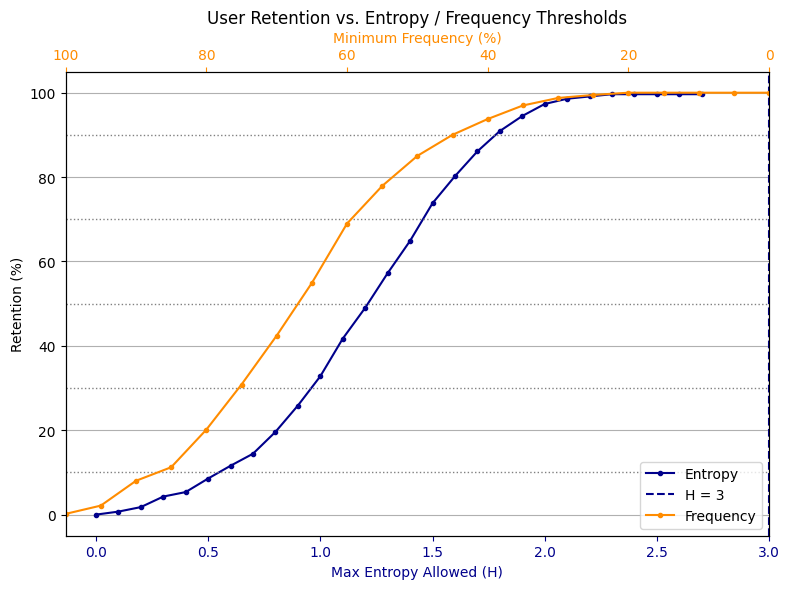

In [19]:
# -------- Sweep thresholds --------

# Entropy thresholds from 0 to 5 (step 0.1)
entropy_thresholds_fine = np.arange(0, 5.01, 0.1)
entropy_retentions = np.array([
    retention(user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=thr)))
    for thr in entropy_thresholds_fine
])

# Detect plateau: retention unchanged for 5 consecutive points
plateau_len = 5
clip_index = None
for i in range(len(entropy_retentions) - plateau_len + 1):
    window = entropy_retentions[i:i+plateau_len]
    if np.all(window == window[0]):  # all values identical
        clip_index = i + plateau_len - 1
        break

if clip_index is not None:
    entropy_thresholds_plot = entropy_thresholds_fine[:clip_index+1]
    entropy_retentions_plot = entropy_retentions[:clip_index+1]
else:
    entropy_thresholds_plot = entropy_thresholds_fine
    entropy_retentions_plot = entropy_retentions

# Frequency thresholds from 0% to 100% (step 5%)
frequency_thresholds_fine = np.arange(0, 1.01, 0.05)
frequency_retentions = [
    retention(user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=thr)))
    for thr in frequency_thresholds_fine
]

# -------- Plot combined --------
fig, ax1 = plt.subplots(figsize=(8, 6))

# Colors
entropy_color = "darkblue"
frequency_color = "darkorange"

# Plot entropy curve
ax1.plot(entropy_thresholds_plot, entropy_retentions_plot, marker="o", markersize=3, color=entropy_color, label="Entropy")
ax1.set_xlabel("Max Entropy Allowed (H)", color=entropy_color)
ax1.set_ylabel("Retention (%)")
ax1.tick_params(axis='x', colors=entropy_color)

# Add ticks for entropy axis
entropy_tick_step = 0.5  # choose step size for ticks
ax1.set_xticks(np.arange(0, entropy_thresholds_plot[-1] + entropy_tick_step, entropy_tick_step))


# Add vertical line at entropy = 3
ax1.axvline(x=3, color=entropy_color, linestyle='--', linewidth=1.5, label="H = 3")

# Add secondary horizontal lines (reference retention values)
for y in [10,30,50,70,90]:
    ax1.axhline(y=y, color='gray', linestyle=':', linewidth=1)


ax1.grid(True, axis="y")

# Create twin x-axis for frequency
ax2 = ax1.twiny()
ax2.plot(frequency_thresholds_fine * 100, frequency_retentions, marker="o", markersize=3, color=frequency_color, label="Frequency")
ax2.set_xlabel("Minimum Frequency (%)", color=frequency_color)
ax2.tick_params(axis='x', colors=frequency_color)
ax2.set_xlim(100, 0)  # invert x axis

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

plt.title("User Retention vs. Entropy / Frequency Thresholds")
plt.tight_layout()
plt.show()

User retention, i.e. users kept using a particular threshold, is low but not nonexistent for H < 3.
(In Cop26 it is 100%).

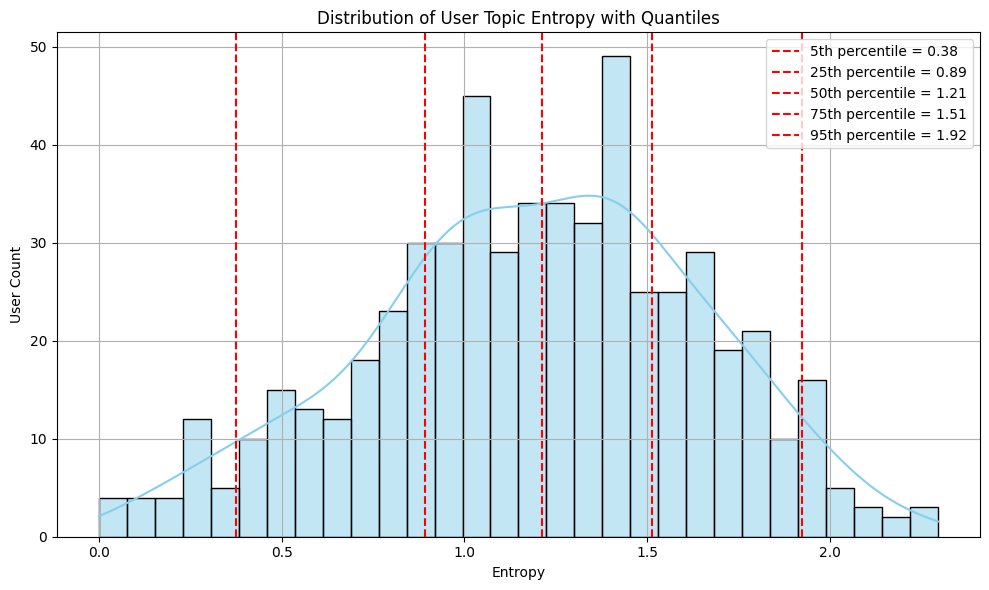

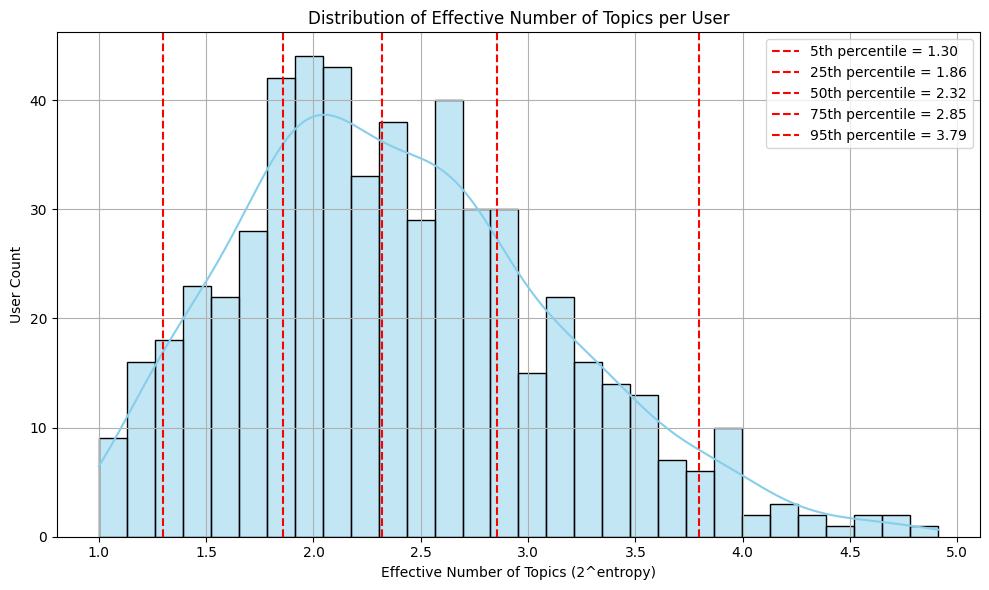

In [20]:
plot_entropy_distribution(user_topic_entropy)

plot_effective_topic_count(user_topic_entropy)

### Examples of Users with High Topic Entropy

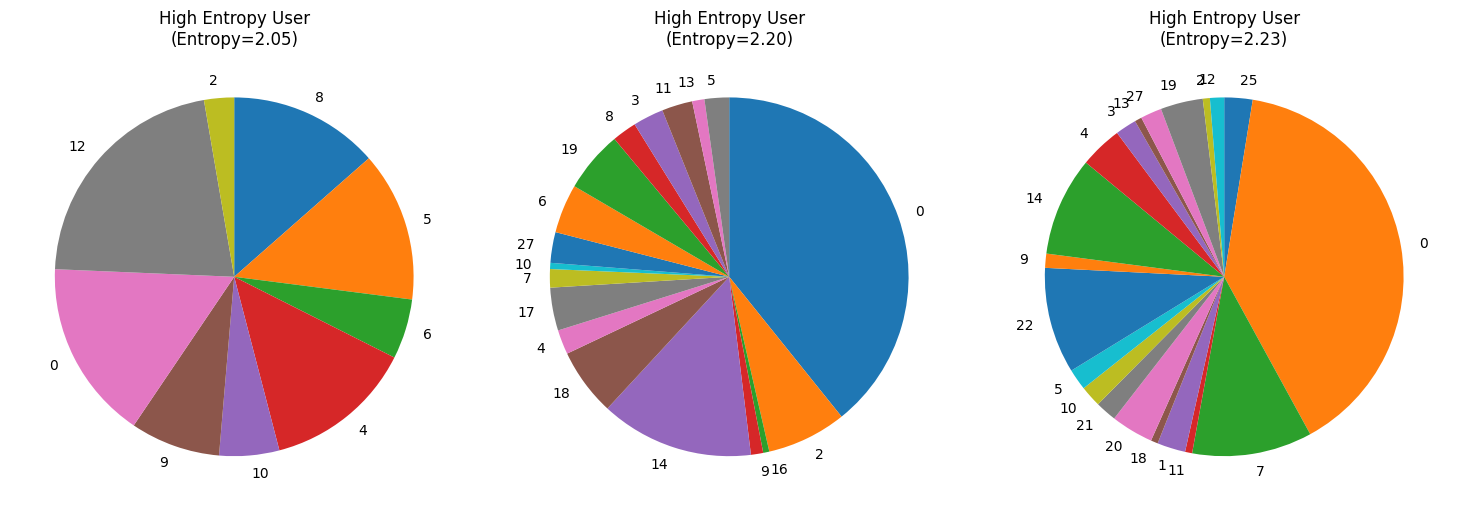

/tmp/ipykernel_112957/668652006.py:28: RuntimeWarning: invalid value encountered in cast
  topics = topics[topics != -1].astype(int)  # exclude noise


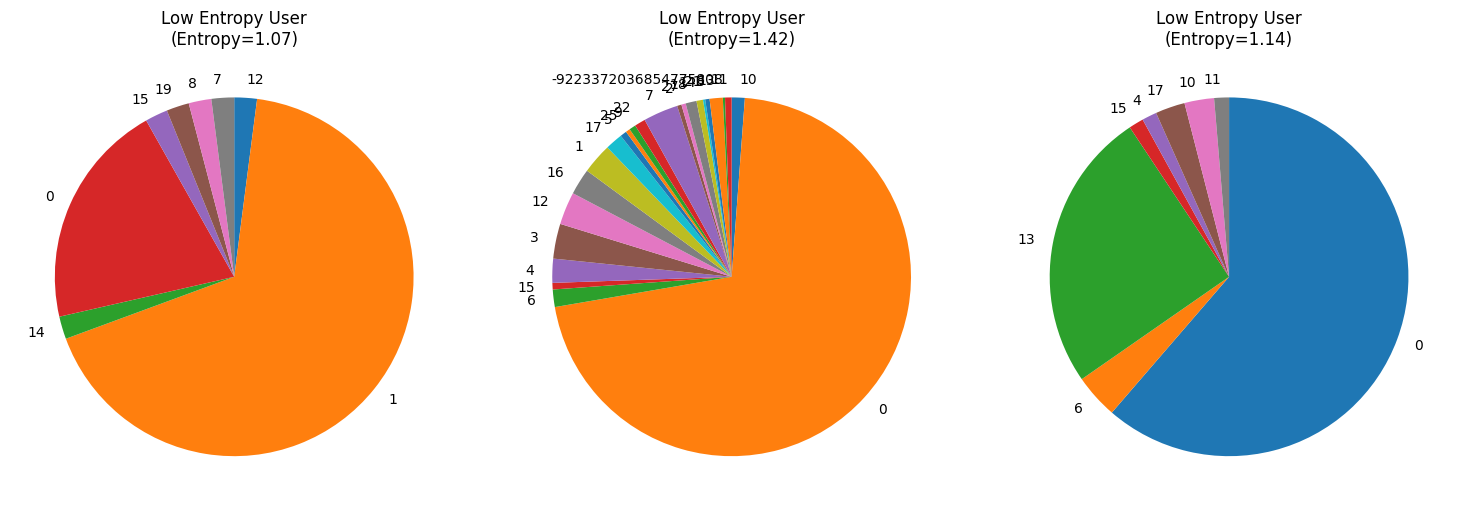

In [21]:
import numpy as np


def plot_user_topic_pies(
    user_topics, user_topic_entropy, condition, n=3, title_prefix=""
):
    """
    Sample n users based on entropy condition and plot pie charts.
    condition: function that takes entropy array and returns a boolean mask
    """
    # Select users that meet the condition
    eligible_users = user_topics.index[condition(user_topic_entropy.values)]

    if len(eligible_users) == 0:
        print("No users found for condition.")
        return

    sampled_users = np.random.choice(
        eligible_users, size=min(n, len(eligible_users)), replace=False
    )

    fig, axes = plt.subplots(1, len(sampled_users), figsize=(5 * len(sampled_users), 5))
    if len(sampled_users) == 1:
        axes = [axes]  # make iterable if only one

    for ax, user_id in zip(axes, sampled_users):
        topics = np.array(user_topics.loc[user_id])
        topics = topics[topics != -1].astype(int)  # exclude noise
        counts = Counter(topics.tolist())

        labels, sizes = zip(*counts.items())
        ax.pie(
            sizes,
            labels=labels,  # autopct="%1.1f%%",
            startangle=90,
            counterclock=False,
        )
        ax.set_title(
            f"{title_prefix}User\n(Entropy={user_topic_entropy.loc[user_id]:.2f})"
        )

    plt.tight_layout()
    plt.show()

h = 3 if chosen_dataset != "cop26_tweets_en" else 2
# --- Usage ---
# 3 users with entropy > 3
plot_user_topic_pies(
    user_topics,
    user_topic_entropy,
    condition=lambda H: H >= h,
    n=3,
    title_prefix="High Entropy ",
)

# 3 users with entropy <= 3
plot_user_topic_pies(
    user_topics,
    user_topic_entropy,
    condition=lambda H: H < h,
    n=3,
    title_prefix="Low Entropy ",
)


## Topic Entropy and User Metadata
Load metadata and combine it with topic entropy to explore results.

In [22]:
# `user_metadata` is a DataFrame with columns like:
# 'id', 'individual_or_org', 'category'
if chosen_dataset == "cop26_tweets_en":
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_cop26.csv")
elif chosen_dataset == "covid_tweets_en":
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_covid.csv")
elif chosen_dataset == "ukraine_tweets_en":
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_ru_ukr.csv")
# print(f"{result.index.dtype}")
user_metadata.id = user_metadata.id.astype(str)
# print(f"{user_metadata['id'].dtype=}")
# user_metadata.columns
# Merge with user-topic assignments from previous step
combined_df = user_metadata.merge(result, left_on="id", right_on="author_id")
# Merge with information on users: political_leaning and reliability
combined_df = combined_df.merge(usr_info, on="username", how="left")

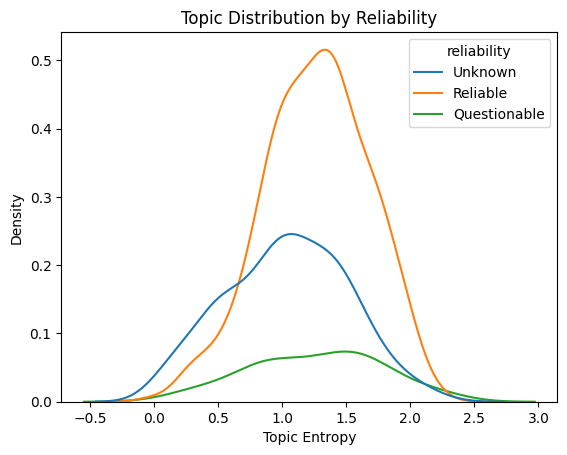

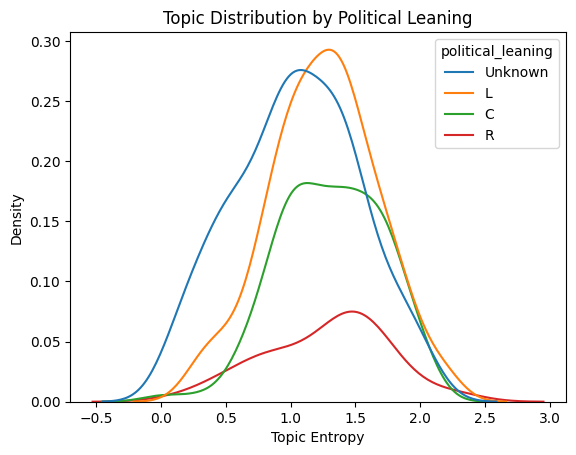

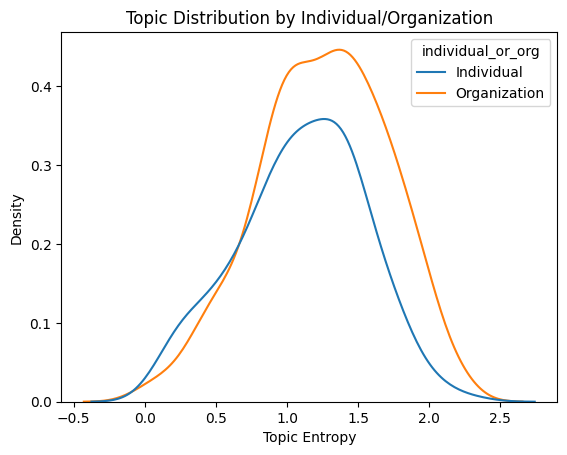

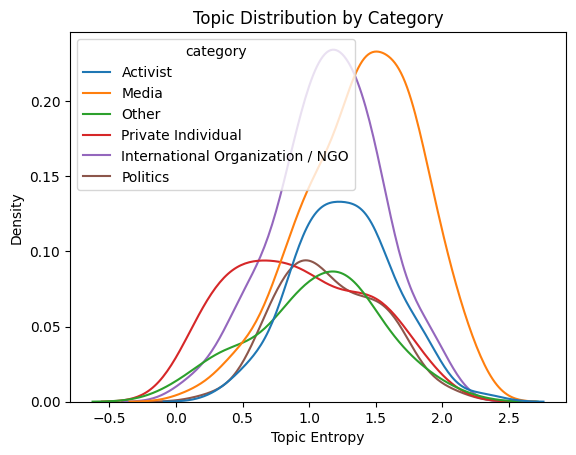

In [23]:
for usr_metadata in [
    "reliability",
    "political_leaning",
    "individual_or_org",
    "category",
]:
    usr_metadata_title = (
        usr_metadata.replace("_", " ")
        .replace(" or ", "/")
        .replace("org", "Organization")
        .title()
    )
    # Produce KDE plots
    sns.kdeplot(data=combined_df, x="topic_entropy", hue=usr_metadata)
    plt.title(f"Topic Distribution by {usr_metadata_title}")
    plt.xlabel("Topic Entropy")
    plt.show()
    # Save plots
    # plt.savefig(f"./../../results/figures/topic_entropy_by_{usr_metadata}.png


## Statistical Test for Association
### Chi²
Use Chi² for categorical association, and Cramer's V
Low p-value (e.g. < 0.05) → strong evidence that topic assignment and political leaning are not independent.
### Cramer's V 
Interpretation of effect size

|Effect size (ES) | Interpretation|
| --------- | --------- |
|ES ≤ 0.2	| The result is weak. Although the result is statistically significant, the fields are only weakly associated.|
|0.2 < ES ≤ 0.6	| The result is moderate. The fields are moderately associated.|
|ES > 0.6	| The result is strong. The fields are strongly associated.|


In [24]:
for variable in ["reliability", "political_leaning", "individual_or_org", "category"]:
    contingency_table = pd.crosstab(
        combined_df[variable],
        combined_df[
            "dominant_topic_8"  # 'dominant_topic_2','dominant_topic_3', 'dominant_topic_4', 'dominant_topic_5', 'dominant_topic_6', 'dominant_topic_8', 'frequent_topic_60', 'frequent_topic_50', 'frequent_topic_30', 'frequent_topic_20', 'frequent_topic_10'
        ],
    )
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\033[33m{variable.upper()}\033[0m")
    effect_size = cramers_v(contingency_table)
    print(f"Chi-square statistic: {chi2}, p-value: {p}")
    print(f"Cramer's V: {effect_size}")
    print(
        f"\033[33m{variable.title()}\033[0m and dominant topic are \033[31m{'not ' * (p > 0.05)}significant\033[0m and \033[31m{'weak' if effect_size <= 0.2 else 'moderate' if effect_size <= 0.6 else 'strong'}ly associated\033[0m."
    )
    print()

RELIABILITY
Chi-square statistic: 37.748060229424254, p-value: 0.7352965109059433
Cramer's V: 0.1839141830552358
Reliability and dominant topic are not significant and weakly associated.

POLITICAL_LEANING
Chi-square statistic: 79.73433533951089, p-value: 0.11931251372347074
Cramer's V: 0.21824533143929636
Political_Leaning and dominant topic are not significant and moderately associated.

INDIVIDUAL_OR_ORG
Chi-square statistic: 41.01319589792659, p-value: 0.008211330501125404
Cramer's V: 0.270866878095574
Individual_Or_Org and dominant topic are significant and moderately associated.

CATEGORY
Chi-square statistic: 177.5220085104113, p-value: 4.8144681788523247e-05
Cramer's V: 0.25202010916615075
Category and dominant topic are significant and moderately associated.



/tmp/ipykernel_112957/2266327594.py:14: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  f"\033{variable.title()}\033 and dominant topic are \033{'not ' * (p > 0.05)}significant\033 and \033{'weak' if effect_size <= 0.2 else 'moderate' if effect_size <= 0.6 else 'strong'}ly associated\033."
/tmp/ipykernel_112957/2266327594.py:14: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  f"\033{variable.title()}\033 and dominant topic are \033{'not ' * (p > 0.05)}significant\033 and \033{'weak' if effect_size <= 0.2 else 'moderate' if effect_size <= 0.6 else 'strong'}ly associated\033."
/tmp/ipykernel_112957/2266327594.py:14: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  f"\033{variable.title()}\033 and dominant topic are \033{'not ' * (p > 0.05)}significant\033 and \033{'weak' if effect_size <= 0.2 else 'moderate' if effect_si

## Tests for difference in distribution

### Mann-Whitney U test
>- Null hypothesis: The probability that a randomly chosen observation from group A is greater than one from group B is equal to the probability it is less.
>- Equivalently, the two distributions are equal in location and shape (assuming continuous data with no ties).
> - tldr: 
>   - two-sided alternative: one distribution **stochastically dominates** the other.
>   - greater (less) alternative: A (B) **tends to have larger values than** B (A).

If distributions differ in spread or shape, the test can still reject, even if medians are the same.

If shapes are identical, then rejecting can be interpreted as a shift in central tendency.
#### Two-sided alternative interpretation
- p < α (e.g., 0.05): Evidence that the two distributions differ (in central location and/or shape).
- p ≥ α: No strong evidence against equality — but lack of evidence is not evidence of equality.
#### One-sided interpretation
With a *greater* alternative, it follows that:

- H₀: Distribution of A is the same as B.
- H₁: Distribution of A is shifted to the right of B (i.e., values in A tend to be larger than in B).
- p < α → Evidence that A tends to have larger values than B.
- p ≥ α → No evidence that A is larger (but could still be smaller or equal).



In [25]:
for variable in [
    "reliability"
]:  # "political_leaning", "individual_or_org", "category"]:
    print(f"\033[33m{variable.upper()}\033[0m")
    A = combined_df[combined_df["reliability"] == "Reliable"]["topic_entropy"].dropna()
    B = combined_df[combined_df["reliability"] == "Questionable"][
        "topic_entropy"
    ].dropna()

    # Mann-Whitney U test
    # alternative can be 'two-sided', 'less', or 'greater'
    u_stat, p_value = mannwhitneyu(A, B, alternative="two-sided")
    r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
    print(f"Mann–Whitney U statistic: {u_stat}")
    print(f"P-value: {p_value:.5f}")
    print(f"Rank Biserial Correlation: {r_rb:.5f}")

    # Optional: interpret
    if p_value < 0.05:
        print("Likely difference between reliable and questionable users (p < 0.05).")
    else:
        print(
            "No significant difference in topic entropy between reliable and questionable users."
        )
    u_stat, p_value = mannwhitneyu(A, B, alternative="greater")
    if p_value < 0.05:
        print(
            "reliable users' topic entropy \33[31mstochastically dominates\33[0m questionable's (p < 0.05)."
        )
    u_stat, p_value = mannwhitneyu(A, B, alternative="less")
    if p_value < 0.05:
        print(
            "reliable users' topic entropy \33[34mis stochastically dominated\33[0m by questionable's (p < 0.05)."
        )
    print()

RELIABILITY
Mann–Whitney U statistic: 9677.0
P-value: 0.97812
Rank Biserial Correlation: 0.00227
No significant difference in topic entropy between reliable and questionable users.



In [26]:
for leaning_a, leaning_b in [
    ("R", "L"),
    ("R", "C"),
    ("C", "L"),
    ("R", "Unknown"),
    ("C", "Unknown"),
    ("L", "Unknown"),
]:  # "political_leaning", "individual_or_org", "category"]:
    print(f"\033[33m{leaning_a} vs {leaning_b} (POLITICAL LEANING)\033[0m")
    A = combined_df[combined_df["political_leaning"] == leaning_a][
        "topic_entropy"
    ].dropna()
    B = combined_df[combined_df["political_leaning"] == leaning_b][
        "topic_entropy"
    ].dropna()

    # Mann-Whitney U test
    # alternative can be 'two-sided', 'less', or 'greater'
    u_stat, p_value = mannwhitneyu(A, B, alternative="two-sided")
    r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
    print(f"Mann–Whitney U statistic: {u_stat}")
    print(f"P-value: {p_value:.5f}")
    print(f"Rank Biserial Correlation: {r_rb:.5f}")

    if p_value < 0.05:
        print(
            f"\33[33mLikely difference\33[0m between {leaning_a} and {leaning_b} -leaning users (p < 0.05)."
        )
    else:
        print(
            f"No significant difference detected between {leaning_a} and {leaning_b} -leaning users."
        )
    u_stat, p_value = mannwhitneyu(A, B, alternative="greater")
    if p_value < 0.05:
        print(
            f"{leaning_a}-leaning users' topic entropy \33[31mstochastically dominates\33[0m {leaning_b}'s (p < 0.05)."
        )
    u_stat, p_value = mannwhitneyu(A, B, alternative="less")
    if p_value < 0.05:
        print(
            f"{leaning_a}-leaning users' topic entropy \33[34mis stochastically dominated\33[0m by {leaning_b}'s (p < 0.05)."
        )
    print()


R vs L (POLITICAL LEANING)
Mann–Whitney U statistic: 4742.0
P-value: 0.56178
Rank Biserial Correlation: -0.05378
No significant difference detected between R and L -leaning users.

R vs C (POLITICAL LEANING)
Mann–Whitney U statistic: 2995.0
P-value: 0.72819
Rank Biserial Correlation: 0.03387
No significant difference detected between R and C -leaning users.

C vs L (POLITICAL LEANING)
Mann–Whitney U statistic: 12072.0
P-value: 0.22621
Rank Biserial Correlation: -0.08172
No significant difference detected between C and L -leaning users.

R vs Unknown (POLITICAL LEANING)
Mann–Whitney U statistic: 6518.0
P-value: 0.00360
Rank Biserial Correlation: -0.26563
Likely difference between R and Unknown -leaning users (p < 0.05).
R-leaning users' topic entropy stochastically dominates Unknown's (p < 0.05).

C vs Unknown (POLITICAL LEANING)
Mann–Whitney U statistic: 16838.0
P-value: 0.00000
Rank Biserial Correlation: -0.31835
Likely difference between C and Unknown -leaning users (p < 0.05).
C-lea

In [27]:
print(f"\033[33mINDIVIDUAL vs ORGANIZATION\033[0m")
A = combined_df[combined_df["individual_or_org"] == "Individual"][
    "topic_entropy"
].dropna()
B = combined_df[combined_df["individual_or_org"] == "Organization"][
    "topic_entropy"
].dropna()


# Mann-Whitney U test
# alternative can be 'two-sided', 'less', or 'greater'
u_stat, p_value = mannwhitneyu(A, B, alternative="two-sided")
r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
print(f"Mann–Whitney U statistic: {u_stat}")
print(f"P-value: {p_value:.5f}")
print(f"Rank Biserial Correlation: {r_rb:.5f}")

# Optional: interpret
if p_value < 0.05:
    print(
        "\033[31mLikely difference\033[0m between Individual and Organization users (p < 0.05)."
    )
else:
    print(
        "\033[35mNo significant difference\033[0m in topic entropy between Individual and Organization users."
    )
u_stat, p_value = mannwhitneyu(A, B, alternative="greater")
if p_value < 0.05:
    print(
        "Individual users' topic entropy \33[31mstochastically dominates\33[0m Organization's (p < 0.05)."
    )
u_stat, p_value = mannwhitneyu(A, B, alternative="less")
if p_value < 0.05:
    print(
        "Individual users' topic entropy \33[36mis stochastically dominated\33[0m by Organization's (p < 0.05)."
    )


INDIVIDUAL vs ORGANIZATION
Mann–Whitney U statistic: 31408.0
P-value: 0.00018
Rank Biserial Correlation: 0.18463
Likely difference between Individual and Organization users (p < 0.05).
Individual users' topic entropy is stochastically dominated by Organization's (p < 0.05).


##### Dead Code

In [28]:
# Use crosstabs and grouped bar plots to explore distributions.
# Crosstab example
# pd.crosstab(
#    combined_df["individual_or_org"],
#    combined_df["dominant_topic_3"],
#    normalize="index",
# )
# pd.crosstab(combined_df["category"], combined_df["dominant_topic_3"], normalize="index")
# sns.countplot(data=combined_df, x="dominant_topic_2", hue="individual_or_org")
# plt.title("Topic Distribution by individual_or_org")
# plt.xticks(rotation=45)
# plt.show()
# sns.countplot(data=combined_df, x="dominant_topic_2", hue="reliability")
# plt.title("Topic Distribution by individual_or_org")
# plt.xticks(rotation=45)
# plt.show()
# sns.countplot(data=combined_df, x="dominant_topic_2", hue="political_leaning")
# plt.title("Topic Distribution by individual_or_org")
# plt.xticks(rotation=45)
# plt.show()
# sns.countplot(data=combined_df, x="dominant_topic_5", hue="category")
# plt.title("Topic Distribution by Category")
# plt.xticks(rotation=45)
# plt.show()


In [29]:
# Using Cliff's Δ and Rank-biserial correlation
# compare_groups(A, B, alternative="two-sided")